# Creating custom datablocks for 3D images and fastai

In [1]:
import SimpleITK as sitk
import re
import pathlib

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.data import *
from faimed3d.models import *


## Load data

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')

train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [4]:
random.shuffle(valid_files)

In [5]:
files = train_files + valid_files

In [6]:
# take only T2 images for now
subset_files =[]
for f in files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_files.append(Path(m.string))

In [7]:
segmentation_files = [(p.parent/'Annotation').ls()[0] for p in subset_files]

## Construct databunch

In [8]:
def GreatGreatGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the great great grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _great_great_grandparent_idxs(o, train_name),_great_great_grandparent_idxs(o, valid_name)
    return _inner

In [9]:
def _great_great_grandparent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.parent.parent.parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

In [10]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(codes = ['void', "peripheral", 'transitional', 'cancer'])),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0.1, 0.15, 0.15), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((2, 2), (25,25), (25,25)), (1, 10, 10)), 
        ClampMask3D,
        PseudoColor],
    splitter = RandomSplitter())

In [11]:
d = pd.DataFrame({'image' : subset_files, 
                  'mask' : segmentation_files})

In [12]:
dls = mris.dataloaders(d, 
                       batch_size = 10, 
                       num_workers = 0,
                      )
dls.valid.bs = 10 # defaults to 64 and will cause Cuda out of Memory errors

In [13]:
SaveModelCallback??

Init signature:
SaveModelCallback(
    monitor='valid_loss',
    comp=None,
    min_delta=0.0,
    fname='model',
    every_epoch=False,
    with_opt=False,
)
Source:        
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta)
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,with_opt')

    def _save(self, name):
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if sel

## Train the model

In [15]:
mcc_loss = MCCLossBinary()

learn = Learner(dls, 
                UNet3D(n_channels = 1, n_classes = 1),
                opt_func = SGD, 
                loss_func = mcc_loss, 
                metrics = mcc_binary, 
                model_dir = '../models/',
                cbs = SaveModelCallback(monitor = 'mcc_binary', fname = 'unet-whole-prostate')
               )
learn = learn.to_fp16()
learn.unfreeze()

In [16]:
#learn.lr_find()

In [17]:
learn.fit_one_cycle(10, 0.5)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.960227,0.970761,0.186866,00:44
1,0.923575,0.873538,0.240698,00:29
2,0.878312,0.738519,0.334510,00:29
3,0.837425,0.690788,0.336235,00:29
4,0.803298,0.683707,0.328751,00:29
5,0.768805,0.606206,0.404943,00:29
6,0.737481,0.444530,0.573612,00:28
7,0.705624,0.416189,0.603887,00:29
8,0.668526,0.408858,0.610400,00:28
9,0.650982,0.386679,0.635172,00:29


Better model found at epoch 0 with mcc_binary value: 0.18686574697494507.
Better model found at epoch 1 with mcc_binary value: 0.24069805443286896.
Better model found at epoch 2 with mcc_binary value: 0.3345097601413727.
Better model found at epoch 3 with mcc_binary value: 0.33623483777046204.
Better model found at epoch 5 with mcc_binary value: 0.40494346618652344.
Better model found at epoch 6 with mcc_binary value: 0.5736124515533447.
Better model found at epoch 7 with mcc_binary value: 0.6038873791694641.
Better model found at epoch 8 with mcc_binary value: 0.6103999614715576.
Better model found at epoch 9 with mcc_binary value: 0.6351720690727234.


In [18]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-0')

Path('../models/unet-whole-prostate-0.pth')

In [19]:
learn.fit_one_cycle(10, 0.25)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.609306,0.405782,0.615116,00:29
1,0.599495,0.499502,0.509980,00:30
2,0.584925,0.399716,0.615448,00:29
3,0.593861,0.522412,0.482547,00:30
4,0.576495,0.498320,0.507902,00:29
5,0.565103,0.443884,0.564806,00:29
6,0.562123,0.417121,0.594847,00:28
7,0.553472,0.362493,0.651250,00:30
8,0.543743,0.371464,0.641372,00:30
9,0.539174,0.343711,0.669498,00:30


Better model found at epoch 0 with mcc_binary value: 0.6151159405708313.
Better model found at epoch 2 with mcc_binary value: 0.6154484152793884.
Better model found at epoch 7 with mcc_binary value: 0.6512500643730164.
Better model found at epoch 9 with mcc_binary value: 0.6694979071617126.


In [20]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-1')

Path('../models/unet-whole-prostate-1.pth')

In [21]:
learn.fit_one_cycle(15, 0.1)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.529917,0.346897,0.664148,00:29
1,0.520277,0.358946,0.651641,00:29
2,0.497784,0.362437,0.647629,00:29
3,0.521099,0.359299,0.652732,00:30
4,0.511605,0.367620,0.638483,00:30
5,0.521620,0.389084,0.618376,00:29
6,0.523951,0.358027,0.651047,00:29
7,0.527605,0.370752,0.639032,00:29
8,0.518197,0.411135,0.596790,00:29
9,0.520576,0.369657,0.639317,00:29


Better model found at epoch 0 with mcc_binary value: 0.6641478538513184.
Better model found at epoch 13 with mcc_binary value: 0.6684280037879944.


In [22]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-2')

Path('../models/unet-whole-prostate-2.pth')

In [23]:
learn.fit_one_cycle(20, 0.01)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.486335,0.348634,0.660294,00:28
1,0.498948,0.347416,0.661800,00:29
2,0.499511,0.347148,0.663015,00:29
3,0.495793,0.343015,0.666954,00:29
4,0.506149,0.339745,0.669921,00:29
5,0.505572,0.353140,0.657315,00:29
6,0.498244,0.341548,0.667749,00:28
7,0.508421,0.334435,0.675244,00:29
8,0.523749,0.363327,0.645492,00:29
9,0.523960,0.341805,0.667521,00:29


Better model found at epoch 0 with mcc_binary value: 0.6602943539619446.
Better model found at epoch 1 with mcc_binary value: 0.6617995500564575.
Better model found at epoch 2 with mcc_binary value: 0.6630149483680725.
Better model found at epoch 3 with mcc_binary value: 0.6669539213180542.
Better model found at epoch 4 with mcc_binary value: 0.6699208617210388.
Better model found at epoch 7 with mcc_binary value: 0.6752440333366394.
Better model found at epoch 13 with mcc_binary value: 0.6766909956932068.


In [24]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-3')

Path('../models/unet-whole-prostate-3.pth')

In [25]:
learn.fit_one_cycle(25, 0.001)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.596481,0.347717,0.661963,00:28
1,0.597067,0.346796,0.663297,00:29
2,0.549771,0.352953,0.656607,00:29
3,0.516445,0.346520,0.663000,00:28
4,0.516210,0.346388,0.663143,00:29
5,0.513153,0.344082,0.665540,00:29
6,0.500980,0.333188,0.675935,00:29
7,0.516194,0.358625,0.650852,00:29
8,0.521926,0.342443,0.667012,00:29
9,0.517900,0.337637,0.672269,00:29


Better model found at epoch 0 with mcc_binary value: 0.6619631052017212.
Better model found at epoch 1 with mcc_binary value: 0.6632967591285706.
Better model found at epoch 5 with mcc_binary value: 0.6655399799346924.
Better model found at epoch 6 with mcc_binary value: 0.6759348511695862.
Better model found at epoch 12 with mcc_binary value: 0.6785964369773865.


In [26]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-4')

Path('../models/unet-whole-prostate-4.pth')

In [27]:
learn.fit_one_cycle(100, 0.0001)

epoch,train_loss,valid_loss,mcc_binary,time
0,0.495894,0.340958,0.668464,00:28
1,0.503617,0.346164,0.663523,00:28
2,0.510479,0.341688,0.667621,00:29
3,0.491013,0.330455,0.678214,00:28
4,0.489022,0.337861,0.671680,00:28
5,0.493487,0.333053,0.676809,00:29
6,0.500074,0.347628,0.662108,00:29
7,0.504921,0.335417,0.674113,00:28
8,0.509679,0.343697,0.665886,00:29
9,0.509541,0.341874,0.667664,00:29


Better model found at epoch 0 with mcc_binary value: 0.6684637665748596.
Better model found at epoch 3 with mcc_binary value: 0.6782140135765076.
Better model found at epoch 63 with mcc_binary value: 0.679779589176178.


In [28]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-5')

Path('../models/unet-whole-prostate-5.pth')

In [29]:
x_in, y_pred, y_orig = learn.get_preds(with_input = True)

In [30]:
x_in = TensorDicom3D(x_in)
y_pred = TensorDicom3D(y_pred)
y_orig = TensorDicom3D(torch.clamp(y_orig, 0, 1))

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:75: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Assuming the 1st dimension is a (fake) color channel it will be removed
  warn(w)


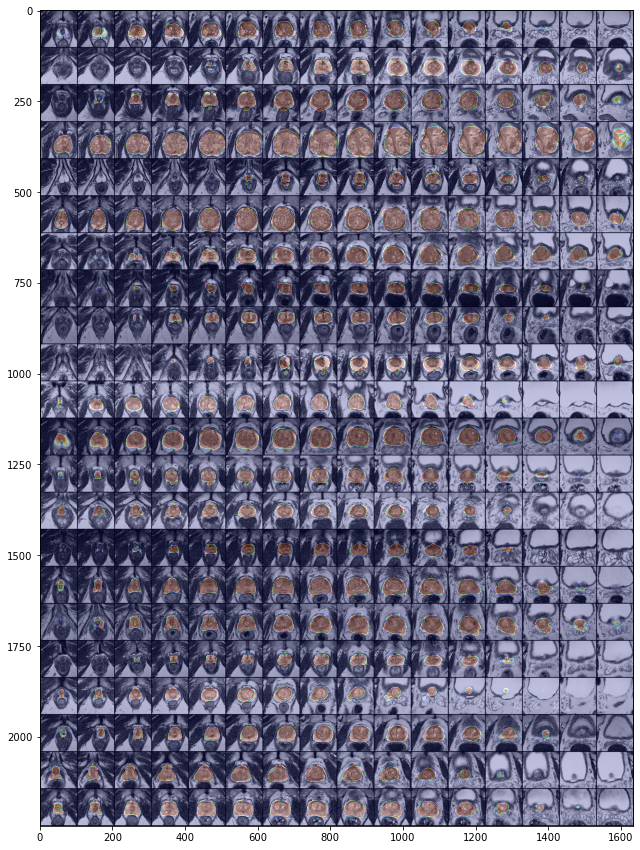

In [31]:
x_in.show(cmap = 'gray', nrow = 16)
y_pred.show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)

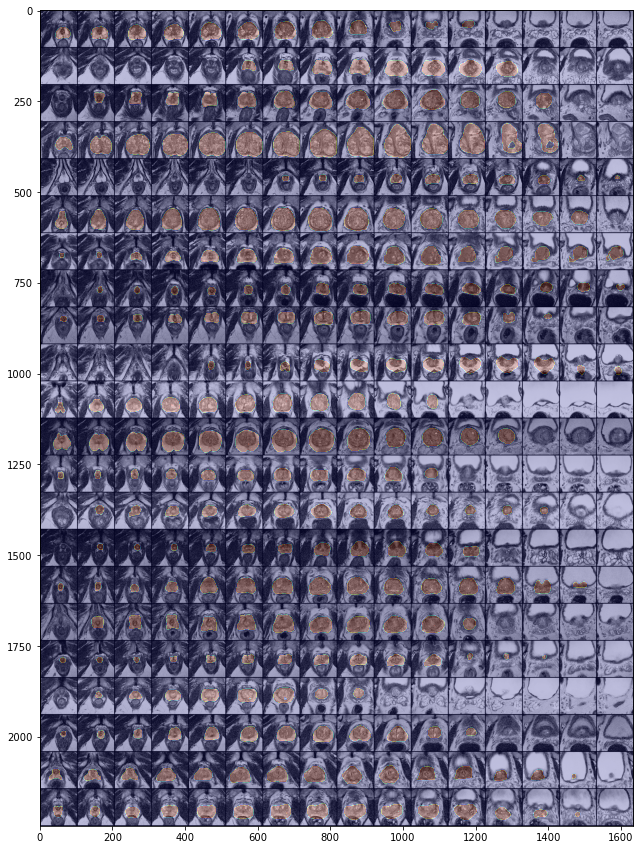

In [32]:
x_in.show(cmap = 'gray', nrow = 16)
y_orig.show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)